The goal of the project is to create an automatic lesion detection model. A MaskRCNN with ResNet50 backbone is used and the training data is a set of images along with the labels whichs are coordinates of bounding boxes around the lesion. Two intersectiing lines are given for each lesion which are used to contruct a psudo mask for the lesion. More details on this construction can be found at https://arxiv.org/pdf/1901.06359.pdf under the section "Pseudo Mask Construction"

Due to size limitation training on a meaningful size of the dataset cannot be done on a Jupyter Notebook running on a CPU. For purposes of creating a prototype I will demostrate that a single image can be trained and demostrate how the loss function decrease. 

Import required libraries

In [1]:
import cv2
from matplotlib import pyplot as plt
import time
import gc
import numpy as np
import torch
from torchvision.transforms import functional as TF
from torch.optim import lr_scheduler, SGD, Adam
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

Load image from disk

In [2]:
img = cv2.imread('toyexample/004408_01_02_088.png', -1)

Subtract 32768from the pixel intensity to obtain the original Hounsfield unit (HU) values
https://nihcc.app.box.com/v/DeepLesion/file/306056134060

In [3]:
img = img.astype(np.float32, copy=False) - 32768

Intensity windowing with window [-1024, 3071] HU covers the intensity ranges of the lung, soft tissue, and bone.
(https://arxiv.org/pdf/1806.09648.pdf)
convert the intensities in a certain range (“window”) to 0-255 for viewing.

In [4]:
img -= -1024
img /= 3071 + 1024
img[img > 1] = 1
img[img < 0] = 0
img *= 255
img = img.astype('uint8')

convert image to tensor. The output tensor will have range [0,1]

In [5]:
img_T = TF.to_tensor(img)

Create numpy array version of img_T Tensor and add a blue pseudo_mask and green bounding box. The addition of the mask (by combining 4 quarter sized ellipses) and bounding box on this numpy version does not affect original image tensor (img_T)

In [6]:
img_copy = [img_T.squeeze().numpy()] * 3
img_copy = cv2.merge(img_copy)
bbox = np.array([188.354, 159.003, 223.22, 183.271])
bbox = np.int16(bbox)
cen = np.array([212.17824058, 171.81745919])
semi_axes = np.array([7, 7, 17, 6])
angles = np.array([0.94002174, -179.05997826])
cv2.ellipse(img_copy, tuple(cen.astype(int)), tuple(semi_axes[0:2]), angles[0], 0, 90, 255, -1)
cv2.ellipse(img_copy, tuple(cen.astype(int)), tuple(semi_axes[2:0:-1]), angles[1], -90, 0, 255, -1)
cv2.ellipse(img_copy, tuple(cen.astype(int)), tuple(semi_axes[2:4]), angles[1], 0, 90, 255, -1)
cv2.ellipse(img_copy, tuple(cen.astype(int)), tuple([semi_axes[0], semi_axes[3]]), angles[0], -90, 0, 255, -1)
cv2.rectangle(img_copy, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

Extract pseudo_mask by identifying pixels which are colored blue

In [7]:
pseudo_mask = np.logical_and(img_copy[:, :, 0] == 255, img_copy[:, :, 1] == 0, img_copy[:, :, 2] == 0).astype('uint8')
pseudo_mask_T = torch.from_numpy(pseudo_mask)

Construct inputs to model

In [8]:
inputs = [img_T]
bbox_T = torch.from_numpy(bbox).float()
bboxes = [bbox_T]
bboxes = torch.stack(bboxes)
masks = [pseudo_mask_T]
masks = torch.stack(masks)
label = torch.ones(len(bboxes), dtype=torch.int64)
elem = {'boxes': bboxes, 'masks': masks, 'labels': label}
targets = [elem]

Check if inputs to model can be displayed correctly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


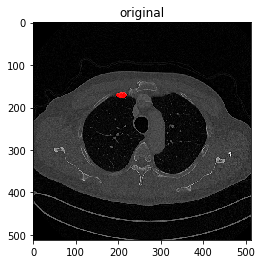

In [9]:
for (image, target) in zip(inputs, targets):
    img_display = image.squeeze().numpy()
    images_disp = [img_display] * 3
    images_disp = [im.astype(float) for im in images_disp]
    img_display = cv2.merge(images_disp)
    for (bbox_disp, pseudo_mask_disp) in zip(target["boxes"], target["masks"]):
        bbox_disp = bbox_disp.squeeze().numpy()
        bbox_disp = np.int16(bbox)
        mask_disp = pseudo_mask_disp.squeeze().numpy()
        cv2.rectangle(img_display, (bbox_disp[0], bbox_disp[1]), (bbox_disp[2], bbox_disp[3]), (0, 255, 0), 1)
        msk_idx = np.where(mask_disp == 1)
        img_display[msk_idx[0], msk_idx[1], 0] = 255
    # cv2.imshow('original', img_display)
    # cv2.cvtColor(img_display, cv2.COLOR_RGB2BGR)
    plt.imshow(img_display)
    plt.title('original')
    plt.show()

Create a pretrained MaskRCNN model with ResNet50 backbone and freeze all layers. Model is pre-trained on COCO train2017
https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.detection.maskrcnn_resnet50_fpn

In [10]:
model = maskrcnn_resnet50_fpn(pretrained=True, max_size=512, min_size=512)
for param in model.parameters():
    param.requires_grad = False

In [11]:
    num_classes = 2  # 1 class (lesion) + 0 (background)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)


The above newly created mask and box predictor will have required_grad=True and therefore these layers of the model will not be forzen. Create a list of parameters where required_grad=True 

In [12]:
params = [p for p in model.parameters() if p.requires_grad]

In [13]:
# Observe that not all parameters are being optimized
# optimizer_ft = SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0001)
optimizer_ft = Adam(params, lr=0.001)

In [14]:
# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.001)

In [15]:
num_epochs = 10
since = time.time()
model.train()

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
         

In [16]:
# print('momentum:' + str(optimizer_ft.state_dict()['param_groups'][0]['momentum']))
print('weight_decay:' + str(optimizer_ft.state_dict()['param_groups'][0]['weight_decay']))
print('LR decay gamma:' + str(exp_lr_scheduler.state_dict()['gamma']))
print('LR decay step size:' + str(exp_lr_scheduler.state_dict()['step_size']))

weight_decay:0
LR decay gamma:0.001
LR decay step size:5


In [17]:
for epoch in range(num_epochs):
    print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    print('lr:' + str(optimizer_ft.state_dict()['param_groups'][0]['lr']))
    loss_dict = model(inputs, targets)
    for (k, i) in loss_dict.items():
        print(str(k) + ':' + str(i))
    losses = sum(loss for loss in loss_dict.values())
    # del loss_dict
    print('Total Train Loss: {:.4f}'.format(losses.item()))

    # zero the parameter gradients
    optimizer_ft.zero_grad()
    # perform backward propagation, optimization and update model parameters
    losses.backward()
    optimizer_ft.step()
    exp_lr_scheduler.step()
#     del losses
#     gc.collect()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


Epoch 0/9
----------
lr:0.001
loss_classifier:tensor(0.7946, grad_fn=<NllLossBackward>)
loss_box_reg:tensor(0.0056, grad_fn=<DivBackward0>)
loss_mask:tensor(2.1112, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
loss_objectness:tensor(0.2223)
loss_rpn_box_reg:tensor(0.0135)
Total Train Loss: 3.1472

Epoch 1/9
----------
lr:0.001
loss_classifier:tensor(0.4448, grad_fn=<NllLossBackward>)
loss_box_reg:tensor(0.0033, grad_fn=<DivBackward0>)
loss_mask:tensor(2.1555, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
loss_objectness:tensor(0.2321)
loss_rpn_box_reg:tensor(0.0135)
Total Train Loss: 2.8492

Epoch 2/9
----------
lr:0.001
loss_classifier:tensor(0.2404, grad_fn=<NllLossBackward>)
loss_box_reg:tensor(0.0028, grad_fn=<DivBackward0>)
loss_mask:tensor(2.0060, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
loss_objectness:tensor(0.2221)
loss_rpn_box_reg:tensor(0.0135)
Total Train Loss: 2.4847

Epoch 3/9
----------
lr:0.001
loss_classifier:tensor(0.1294, grad_fn=<NllLossBackward>)
loss_

The above shows that the loss converges at around 0.6. Now the model can be run on a sizable dataset in production on a GPU to see how inference is done. Once in production the sensiticity of the model can be checked by counting the percentage of correct lesion detections over the number of labled lesions. At the same time the number of false positives ( lesion detections by the model which are not in reality a lesion) should be taken into account. The goal is to maximize the sensitivty of the model and at the same time minimize the false positive rate per image.